<h1>Assignment: "Hello, Graph World"</h1>
<h2>By Brian Weinfeld</h2>

In [1]:
%matplotlib inline
from neo4j.v1 import GraphDatabase
import csv
import networkx as nx
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

For this assignment I created a csv file with a series of relationships between people. I will use Python to read it into a Neo4j graph and then query the graph to read it into a networkx graph. Finally, I will the display the graph with relationships.

In [2]:
class BeachHead(object):

    def __init__(self, uri, user, password):
        self._driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self._driver.close()

    def delete(self):
        with self._driver.session() as session:
            session.run('MATCH (n) DETACH DELETE n')
            session.run('CREATE CONSTRAINT ON (p:Person) ASSERT p.name IS UNIQUE')

    def add_relationship(self, a, b, type):
        with self._driver.session() as session:
            session.run('MERGE (a:Person {name: $a})'
                        'MERGE (b:Person {name: $b})'
                        'CREATE (a)-[k:KNOWS]->(b)'
                        'SET k.type = {type}'
                        'CREATE (b)-[l:KNOWS]->(a)'
                        'SET l.type = {type}', a=a, b=b, type=type)

    def query(self, query):
        with self._driver.session() as session:
            return session.run(query)


The above code is a basic driver for Neo4j and will be used below.

In [6]:
if __name__ == '__main__':
    neo = BeachHead('bolt://localhost:7687', 'cuny', 'password')
    neo.delete()

    with open('relationships.csv', newline='') as csvfile:
        for r in csv.reader(csvfile, delimiter=','):
            print(f'{r[0]} {r[2]} {r[1]}')
            neo.add_relationship(r[0], r[1], r[2])

Andre KNOWS Carol
Andre KNOWS Diane
Andre WORKS Beverly
Beverly WORKS Diane
Beverly LIKES Ed
Beverly KNOWS Garth
Carol LIKES Diane
Carol WORKS Frank
Frank LIKES Diane
Frank WORKS Garth
Frank WORKS Heather
Heather KNOWS Ike
Ike KNOWS Jane


The above code reads in the csv file and adds the data to the Neo4j graph. The information that has been read in is displayed for verification purposes.

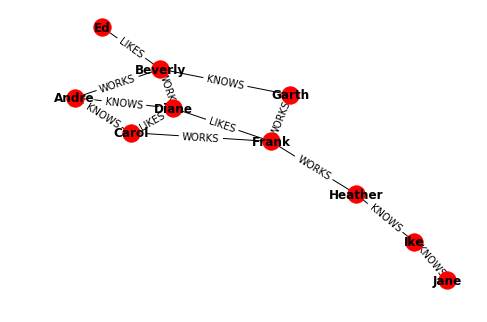

In [7]:
results = [(n1, n2, {'rel': k}) for n1, n2, k in 
                neo.query('MATCH (p:Person)-[k:KNOWS]->(p2:Person) '
                          'WHERE p.name < p2.name '
                          'RETURN p.name, p2.name, k.type '
                          'ORDER BY p.name, p2.name'
                         )
               ]
neo.close()
G = nx.Graph()
G.add_edges_from(results)
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, font_weight='bold', pos=pos)
edge_labels = dict([((u, v), d['rel']) for u, v, d in G.edges(data=True)])
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels = edge_labels)
plt.show()

The above code queries the Neo4j database for the